In [1]:
import os
import glob
import cv2
import utils
import pydicom as dicom
import plistlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

from utils import *
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [2]:
dataFolderPath = 'INbreast Release 1.0' # SET INbreast FOLDER PATH
saveFolderPath = 'data' # SET Which Folder to Save
foldCount = 5 # SET K-FOLD Validation
massClassification = False # SET False for Mass Class, SET True for Malign-Benign Classes

In [3]:
'''Loading XML files and reading DataFrame'''
xmlFiles = sorted(glob.glob(os.path.join(dataFolderPath, 'AllXML', '*')))
df = pd.read_excel(os.path.join(dataFolderPath, 'INbreast.xls'))
df

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Mass,Micros,Distortion,Asymmetry,Findings Notes (in Portuguese),Other Notes,Lesion Annotation Status,Pectoral Muscle Annotation,Other Annotations
0,removed,removed,R,CC,201001.0,22678622.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN
1,removed,removed,L,CC,201001.0,22678646.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN
2,removed,removed,R,MLO,201001.0,22678670.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN
3,removed,removed,L,MLO,201001.0,22678694.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN
4,removed,removed,R,CC,201001.0,22614074.0,2,5,X,X,NaN,NaN,nódulo QSE + micros,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,removed,removed,R,MLO,200802.0,24055752.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN
408,removed,removed,L,CC,200802.0,24055779.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN
409,removed,removed,R,CC,200802.0,24055806.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN
410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
'''Filtering rows where "File Name" column is not NaN'''
df = df[df['File Name'].notna()]
df['File Name'] = df['File Name'].astype('int') # sorgu islemini kolaylastirabilmek icin float olarak tutulmasi gerek yok

/tmp/ipykernel_41698/426763245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['File Name'] = df['File Name'].astype('int') # sorgu islemini kolaylastirabilmek icin float olarak tutulmasi gerek yok


In [5]:
'''Reading XML files and finding mass filenames'''
massFileNames = []
for xmlFile in xmlFiles:
    with open(xmlFile, 'rb') as maskFile:
        plistDict = plistlib.load(maskFile, fmt=plistlib.FMT_XML)['Images'][0]
        
    rois = plistDict['ROIs']
    
    abnormalities = []
    
    for roi in rois:
        numPoints = roi['NumberOfPoints']
        if numPoints == 1:
            continue

        abnormality = roi["Name"]
        abnormalities.append(abnormality)
    
    if 'Mass' in abnormalities:
        massFileNames.append(xmlFile.split(os.path.sep)[-1].split('.')[0])

In [6]:
'''Using mass filenames and filtering mass patients'''
massDicomFilePaths = [glob.glob(os.path.join(dataFolderPath, 'AllDICOMs', str(filename) + '*.dcm'))[0] for filename in massFileNames]
massPatients = [massDicomFilePath.split(os.path.sep)[-1].split('_')[1] for massDicomFilePath in massDicomFilePaths]
massPatients = list(set(massPatients))
print('Total Mass Patient Count:', len(massPatients), 'Total Mass Images:', len(massDicomFilePaths))

Total Mass Patient Count: 50 Total Mass Images: 107


In [7]:
'''Applying 5 Fold Cross Validation Based on Mass Patients'''
kf = KFold(n_splits=foldCount, shuffle=True, random_state=9)
patientFolds = []
for trainIndex, valIndex in kf.split(massPatients):
    trainPatients = []
    for i in range(len(trainIndex)):
        trainPatients.append(massPatients[trainIndex[i]])
    testPatients = []
    for i in range(len(valIndex)):
        testPatients.append(massPatients[valIndex[i]])
    patientFolds.append([trainPatients,testPatients])

In [8]:
'''Creates folders and saves images as png and their mask information to annotation text file '''

if not os.path.exists(saveFolderPath):
    os.mkdir(saveFolderPath)

for i in tqdm(range(len(patientFolds)), position=0, leave=True):
    trainPatients = patientFolds[i][0]
    testPatients = patientFolds[i][1]
    
    foldPath = os.path.join(saveFolderPath, 'Fold' + str(i))
    if not os.path.exists(foldPath):
        os.mkdir(foldPath)
    
    trainFoldPath = os.path.join(foldPath, 'train')
    if not os.path.exists(trainFoldPath):
        os.mkdir(trainFoldPath)

    trainImageFoldPath = os.path.join(trainFoldPath, 'images')
    if not os.path.exists(trainImageFoldPath):
        os.mkdir(trainImageFoldPath)

    trainTextFoldPath = os.path.join(trainFoldPath, 'labels')
    if not os.path.exists(trainTextFoldPath):
        os.mkdir(trainTextFoldPath)
    
    for trainPatient in tqdm(trainPatients, desc='Fold ' + str(i) + ' Train Patients', position=0, leave=True):
        trainPatientFilePaths = glob.glob(os.path.join(dataFolderPath, 'AllDICOMs', '*' + str(trainPatient) + '*.dcm'))

        for trainPatientFilePath in trainPatientFilePaths:
            patientFileName = trainPatientFilePath.split(os.path.sep)[-1].split('_')[0]
            
            if patientFileName in massFileNames:
                
                xmlFilePath = os.path.join(dataFolderPath, 'AllXML', patientFileName + '.xml')
                if massClassification:
                    biradsScore = df[df['File Name']==int(patientFileName)]['Bi-Rads'].values[0]
                else:
                    biradsScore = 0
                imageFilePath = utils.saveImages(trainPatientFilePath, trainImageFoldPath)
                maskPath = os.path.join(trainTextFoldPath, imageFilePath.split(os.path.sep)[-1].split('.')[0]) + '.txt'
                imshape = Image.open(imageFilePath).size
                utils.saveMaskYOLOFormat(xmlFilePath, imageFilePath, maskPath, biradsScore, imshape)

    validationFoldPath = os.path.join(foldPath, 'validation')
    if not os.path.exists(validationFoldPath):
        os.mkdir(validationFoldPath)

    validationImageFoldPath = os.path.join(validationFoldPath, 'images')
    if not os.path.exists(validationImageFoldPath):
        os.mkdir(validationImageFoldPath)
    
    validationTextFoldPath = os.path.join(validationFoldPath, 'labels')
    if not os.path.exists(validationTextFoldPath):
        os.mkdir(validationTextFoldPath)
    
    for validationPatient in tqdm(testPatients, desc='Fold ' + str(i) + ' Validation Patients', position=0, leave=True):
        validationPatientFilePaths = glob.glob(os.path.join(dataFolderPath, 'AllDICOMs', '*' + str(validationPatient) + "*.dcm"))

        for validationPatientFilePath in validationPatientFilePaths:
            patientFileName = validationPatientFilePath.split(os.path.sep)[-1].split('_')[0]
            if patientFileName in massFileNames:
                
                xmlFilePath = os.path.join(dataFolderPath, 'AllXML', patientFileName + '.xml')
                if massClassification:
                    biradsScore = df[df['File Name']==int(patientFileName)]['Bi-Rads'].values[0]
                else:
                    biradsScore = 0
                imageFilePath = utils.saveImages(validationPatientFilePath, validationImageFoldPath)
                maskPath = os.path.join(validationTextFoldPath, imageFilePath.split(os.path.sep)[-1].split('.')[0]) + '.txt'
                imshape = Image.open(imageFilePath).size
                utils.saveMaskYOLOFormat(xmlFilePath, imageFilePath, maskPath, biradsScore, imshape)
    break

  0%|          | 0/5 [01:30<?, ?it/s]


In [9]:
validationImageFiles = glob.glob(os.path.join(validationImageFoldPath, '*'))
validationLabelFiles = glob.glob(os.path.join(validationTextFoldPath, '*'))

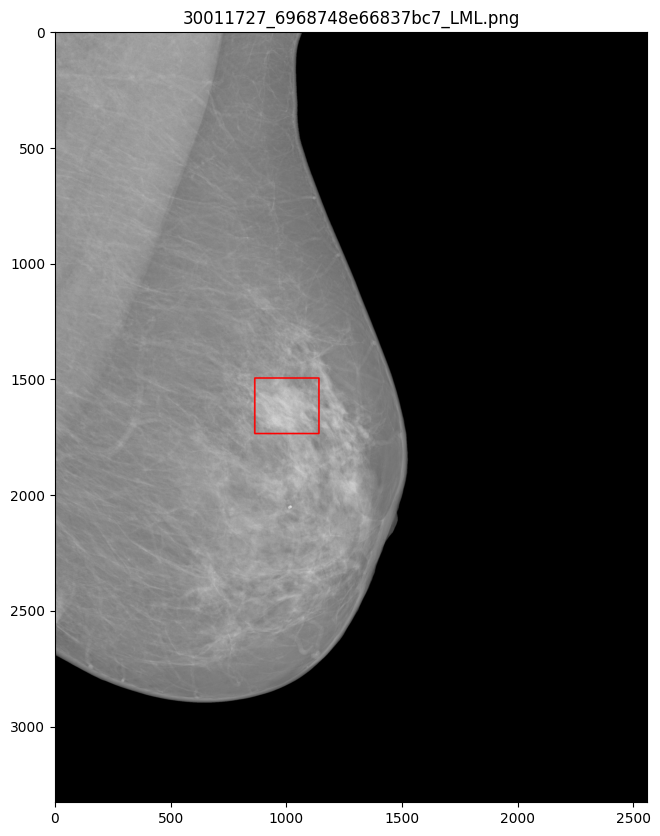

In [10]:
fileIndex = 5
imagePath = validationImageFiles[fileIndex]
textPath = validationLabelFiles[fileIndex]

image = cv2.imread(imagePath)

with open(textPath, 'r') as f:
    data = f.readlines()
    
for j in range(len(data)):
    line = data[j].split()
    draw_annotation(image, line)

plt.figure(figsize=(10,10))
plt.title(imagePath.split(os.path.sep)[-1])
plt.imshow(image)